In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import glob
import joblib
import pandas as pd
#from pathlib import Path
import matplotlib.pyplot as plt

from utils import utils as u
from utils import phone_info as ph_i 
from utils import plots as plots
from sklearn.metrics import silhouette_score, silhouette_samples

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
root = '/Users/tomasandrade/Documents/BSC/ICHOIR/study_phonemes_contentvec/data/songs'
root_umap = '/Users/tomasandrade/Documents/BSC/ICHOIR/study_phonemes_contentvec/assets/umap'
lab_paths = glob.glob(f'{root}/lab/*.lab')

In [18]:
layers_dict = {
    2: 'feat_layer_2',
    5: 'feat_layer_5',
    7: 'feat_layer_7',
    9: 'feat_layer_9',
    12: 'feat'} 

In [9]:
drop_cols = ['phone_base', 'song']

-------- Working on layer 7
-------- umap
Training UMAP with parameters n_components : 2, n_neighbors 100, min_dist : 0.1
Applying dimensional reduction
Reduced to 2 dimensions
-------- plot
Making a 2d plot
-------- silhouette
-------- o -------- 



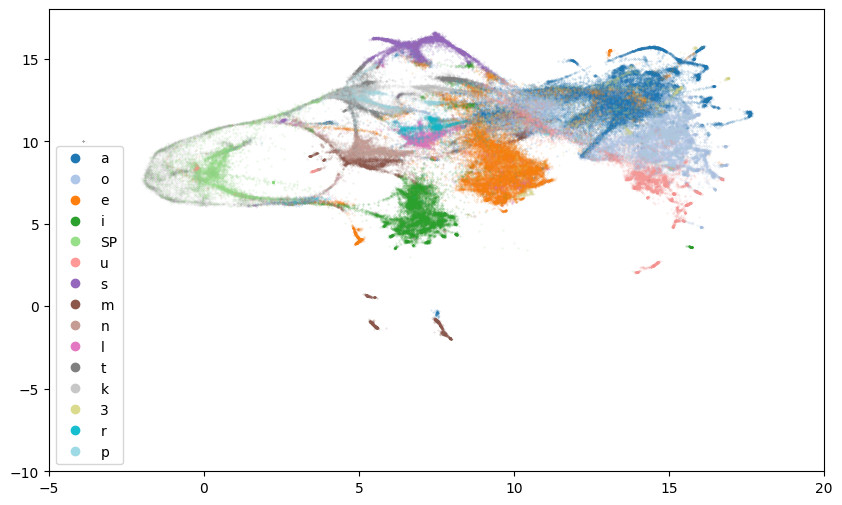

In [17]:
silhouette_dict = {}

#for layer in layers_dict.keys():
for layer in [7]:

    print(f'-------- Working on layer {layer}')
    feat_paths = glob.glob(f'{root}/{layers_dict[layer]}/*.csv')
    df_anotated = u.make_anotated_feat_df(feat_paths, lab_paths)

    ### umap
    print(f'-------- umap')
    umap2 = u.train_umap(
        df_anotated,
        exclude_phones = ['SP'],
        n_components=2, 
        n_neighbors=100, 
        min_dist=0.1,
        save_model = False,
        folder = None)
    
    df_proj_anotated = u.make_proj_anotated_feat_df(df_anotated, 
                                                    umap2,
                                                    save_df = False,
                                                    folder = None)
    
    ### plots
    print(f'-------- plot')
    unique_phones = [k for k in df_anotated['phone_base'].value_counts().keys() if k != 'AP']
    plots.make_tagged_LS_plot(df_proj_anotated,
            phones = unique_phones[:15],
            alpha = 0.25, 
            s = 0.1,
            show_global=True,
            xlim = [ -5, 20],
            ylim = [-10, 18])
    plt.savefig(f'LS_songs_layer_{layer}')
    
    ### silhouettes
    print(f'-------- silhouette')
    X1 = df_anotated.drop(columns = drop_cols).values
    y1 = df_anotated['phone_base'].values
    sil_score = silhouette_score(X1, y1, metric='cosine')

    silhouette_dict[layer] = sil_score

    print(f'-------- o -------- \n')

In [19]:
silhouette_dict = {
2: 0.026745177184901082,
5: 0.024168539539559754,
7: 0.05940969570897242,
9: 0.05940969570897242,
12: 0.061644733461769984}

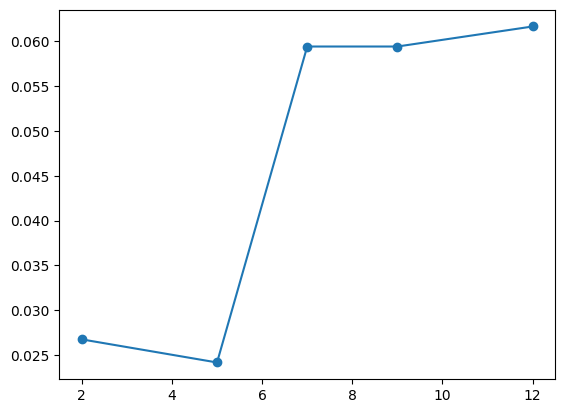

In [21]:
plt.plot(silhouette_dict.keys(), silhouette_dict.values(), '-o')

# MI 

In [6]:
feat_paths = glob.glob(f'{root}/feat/*.csv')
df_anotated = u.make_anotated_feat_df(feat_paths, lab_paths)

In [27]:
df_anotated['phone_base'].unique()

array(['SP', 'm', 't', 'u', 's', 'a', 'p', 'AP', 'n', 'h', 'y', 'o', 'r',
       'i', 'k', 'e', 'd', 'l', 'sh', 'B', 'jh', 'b', '3', 'ch', 'w',
       'll', 'rr', 'D', 'G', '0', 'f', 'cl', 'z', 'N', 'x', 'g', 'Y'],
      dtype=object)

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score
import numpy as np

In [32]:
K = 100

In [33]:
mi_dict = {}
for layer in layers_dict.keys():
    print(f'-------- Working on layer {layer}')
    feat_paths = glob.glob(f'{root}/{layers_dict[layer]}/*.csv')
    df_anotated = u.make_anotated_feat_df(feat_paths, lab_paths)

    c1 = df_anotated['phone_base'] != 'SP'
    c2 = df_anotated['phone_base'] != 'AP'

    df_filter = df_anotated[c1 & c2]

    ### umap
    print(f'-------- MI')
    X = df_filter.drop(columns = drop_cols).values
    y = df_filter['phone_base'].values

    # Step 1: Cluster the embeddings
    kmeans = KMeans(n_clusters=K, random_state=42)
    cluster_assignments = kmeans.fit_predict(X)

    # Step 2: Compute mutual information with phone labels
    mi = mutual_info_score(y, cluster_assignments)

    print(f"Mutual Information (MI-phone): {mi:.4f}")

    mi_dict[layer] = mi

-------- Working on layer 2
-------- MI
Mutual Information (MI-phone): 1.3797
-------- Working on layer 5
-------- MI
Mutual Information (MI-phone): 1.2759
-------- Working on layer 7
-------- MI
Mutual Information (MI-phone): 1.3934
-------- Working on layer 9
-------- MI
Mutual Information (MI-phone): 1.6313
-------- Working on layer 12
-------- MI
Mutual Information (MI-phone): 1.6327


In [36]:
mi_dict_K37 = {
2: 1.2260638058195634,
5: 1.0969315914564457,
7: 1.2477380320655191,
9: 1.481926896351206,
12: 1.4414430856414584}

mi_dict_K50 = {
2: 1.455819511671117,
5: 1.3333187709000631,
7: 1.4914863115846273,
9: 1.6715139245470223,
12: 1.671006164408342}

mi_dict_K100 = {2: 1.3796890791571577,
5: 1.2758649486191334,
7: 1.3934248710902295,
9: 1.631315943406578,
12: 1.6326905345821952}

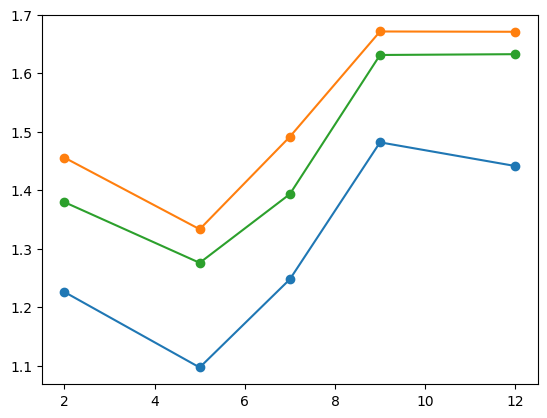

In [37]:
plt.plot(mi_dict_K37.keys(), mi_dict_K37.values(), '-o')
plt.plot(mi_dict_K50.keys(), mi_dict_K50.values(), '-o')
plt.plot(mi_dict_K100.keys(), mi_dict_K100.values(), '-o')